In [ ]:
import tensorflow.keras
import numpy as np
import tensorflow as tf

2024-04-15 01:33:53.282206: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 01:33:53.317985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 01:33:53.942699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
BINARY_SIZE = 1
PATCH_SIZE = 4
BATCH_SIZE = 256

In [ ]:
def load_keras_dataset(dataset_name):
    import keras.datasets as datasets
    (x_train, _), (x_test, _) = getattr(datasets, dataset_name).load_data()

    x_train = np.append(x_train, x_test, axis=0)
    x_train = x_train.astype('float32') / 255.
    return x_train

def load_stl10():
    path = "data/stl10/train_X.bin"

    with open(path, 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8)
        data = data.reshape(-1, 3, 96, 96)
        data = np.transpose(data, (0, 3, 2, 1))
        data = data.astype('float32') / 255.
    return data


def get_data():
    cifar10_dataset = load_keras_dataset('cifar10')
    cifar100_dataset = load_keras_dataset('cifar100')

    # append the datasets
    dataset = np.append(cifar10_dataset, cifar100_dataset, axis=0)
    
    return dataset

def get_simple_data():
    cifar10_dataset = load_keras_dataset('cifar10')

    return cifar10_dataset

In [ ]:
dataset = load_stl10()

In [ ]:
dataset.shape

(5000, 96, 96, 3)

In [ ]:
dataset = tf.image.extract_patches(dataset, sizes=[1, PATCH_SIZE, PATCH_SIZE, 1], strides=[1, PATCH_SIZE, PATCH_SIZE, 1], rates=[1, 1, 1, 1], padding='VALID')

2024-04-15 01:33:56.088051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 01:33:56.116522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 01:33:56.116564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 01:33:56.119212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 01:33:56.119264: I tensorflow/compile

In [ ]:
dataset = tf.reshape(dataset, [-1, PATCH_SIZE, PATCH_SIZE, 3])

In [ ]:
# dataset to ycbcr
dataset = tf.image.rgb_to_yuv(dataset)

2024-04-15 01:33:56.995296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [ ]:
image_input = tensorflow.keras.layers.Input(shape=(PATCH_SIZE, PATCH_SIZE, 3))
x = tensorflow.keras.layers.Conv2D(32, (3, 3), padding='same')(image_input)
x - tensorflow.keras.layers.BatchNormalization()(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tensorflow.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
x - tensorflow.keras.layers.BatchNormalization()(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tensorflow.keras.layers.Conv2D(BINARY_SIZE, (3, 3), padding='same')(x)
x - tensorflow.keras.layers.BatchNormalization()(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
encoded = tensorflow.keras.layers.MaxPooling2D((1, 1), padding='same')(x)

x = tensorflow.keras.layers.Conv2DTranspose(64, (3, 3), padding='same')(encoded)
x - tensorflow.keras.layers.BatchNormalization()(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.UpSampling2D((1,1))(x)
x = tensorflow.keras.layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
x - tensorflow.keras.layers.BatchNormalization()(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
x = tensorflow.keras.layers.Conv2DTranspose(32, (3, 3), padding='same')(x)
x - tensorflow.keras.layers.BatchNormalization()(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
decoded = tensorflow.keras.layers.Conv2DTranspose(3, (3, 3), padding='same')(x)

autoencoder = tensorflow.keras.Model(image_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

autoencoder.fit(dataset, dataset, epochs=10, batch_size=BATCH_SIZE, shuffle=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 3)]         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 32)          896       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4, 4, 32)          0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 2, 2, 64)          0         
                                                           

2024-04-15 01:34:29.767586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907
2024-04-15 01:34:29.866245: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-15 01:34:30.402152: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f9f0a826bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-15 01:34:30.402202: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-04-15 01:34:30.406703: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-15 01:34:30.518893: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-15 01:34:30.573212: I ./tensorflow/compiler/j

11250/11250 [==============================] - 73s 6ms/step - loss: 0.0054
Epoch 2/10
11250/11250 [==============================] - 69s 6ms/step - loss: 0.0052
Epoch 3/10
11250/11250 [==============================] - 69s 6ms/step - loss: 0.0049
Epoch 4/10
11250/11250 [==============================] - 68s 6ms/step - loss: 0.0050
Epoch 5/10
11250/11250 [==============================] - 68s 6ms/step - loss: 0.0051
Epoch 6/10
11250/11250 [==============================] - 69s 6ms/step - loss: 0.0051
Epoch 7/10
11250/11250 [==============================] - 65s 6ms/step - loss: 0.0049
Epoch 8/10
11250/11250 [==============================] - 61s 5ms/step - loss: 0.0049
Epoch 9/10
11250/11250 [==============================] - 64s 6ms/step - loss: 0.0049
Epoch 10/10
11250/11250 [==============================] - 64s 6ms/step - loss: 0.0048


In [ ]:
def pad_image(image: np.ndarray, patch_size: int):
    h, w, c = image.shape
    h_pad = (patch_size - (h % patch_size)) % patch_size
    w_pad = (patch_size - (w % patch_size)) % patch_size

    return np.pad(image, ((0, h_pad), (0, w_pad), (0, 0)), mode='constant', constant_values=0), h_pad, w_pad

In [ ]:
def compress_image(image: np.ndarray, network: tf.keras.Model) -> tuple[np.ndarray, np.ndarray]:
    """
    Compress an image using the given network
    :param image: The image to compress
    :param network: The network to use for compression
    :return: The compressed image & the bits
    """
    patch_size = PATCH_SIZE

    # pad the image
    image, h_pad, w_pad = pad_image(image, patch_size)
    
    height, width, channels = image.shape
    no_patches_width = width // patch_size
    no_patches_height = height // patch_size
    
    # transform image to list with a single element
    image = tf.expand_dims(image, axis=0)

    image = tf.image.extract_patches(image, sizes=[1, patch_size, patch_size, 1], strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding='VALID')
    image = tf.reshape(image, [-1, patch_size,patch_size,3])

    reconstructed_patches = network.predict(image)
    reconstructed_image = np.zeros((height, width, channels))

    for i in range(no_patches_height):
        for j in range(no_patches_width):
            patch = reconstructed_patches[i*no_patches_width+j].reshape(patch_size, patch_size, 3)
            # print(i*patch_size, (i+1)*patch_size, j*patch_size, (j+1)*patch_size)
            reconstructed_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch

    height = height - h_pad
    width = width - w_pad

    reconstructed_image = reconstructed_image[:height, :width]

    # convert reconstructed image to tensor
    reconstructed_image = tf.convert_to_tensor(reconstructed_image)
    reconstructed_image = tf.image.yuv_to_rgb(reconstructed_image) * 255

    return reconstructed_image

In [ ]:
image = tf.image.decode_image(tf.io.read_file('ciob.png'), channels=3, dtype='float32')

image = image
image = tf.image.rgb_to_yuv(image)

reconstructed_image_32 = compress_image(image, autoencoder)
reconstructed_image_32 = tf.cast(reconstructed_image_32, tf.uint8)
# reconstructed_image_32 = reconstructed_image_32 * 255

image = tf.image.yuv_to_rgb(image)
image = tf.cast(image * 255, tf.uint8)

362/362 [==============================] - 2s 4ms/step


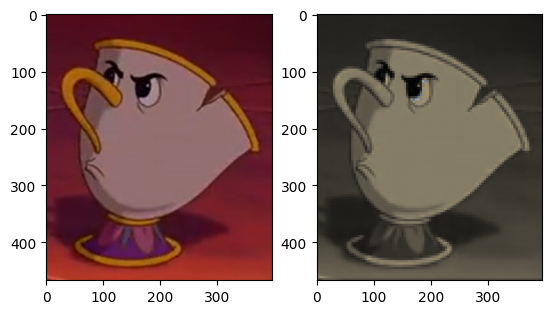

In [ ]:
import matplotlib.pyplot as plt

ax, fig = plt.subplots(1, 2)
fig[0].imshow(image)
fig[1].imshow(reconstructed_image_32)

In [ ]:
# compute psnr
tf.image.psnr(image, reconstructed_image_32, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=18.704021>

In [ ]:
tf.image.ssim(image, reconstructed_image_32, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.78859663>

In [ ]:
tf.image.ssim_multiscale(image, reconstructed_image_32, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.89839166>

In [ ]:
encoder = tensorflow.keras.Model(image_input, encoded)

In [ ]:
image = tf.image.decode_image(tf.io.read_file('ciob.png'), channels=3, dtype='float32')
image = tf.image.rgb_to_yuv(image)

image_, _, _ = pad_image(image, PATCH_SIZE)

no_patches_width = image_.shape[1] // PATCH_SIZE
no_patches_height = image_.shape[0] // PATCH_SIZE

width = image_.shape[1]
height = image_.shape[0]

image_ = tf.expand_dims(image_, axis=0)
img_patches = tf.image.extract_patches(image_, sizes=[1, PATCH_SIZE, PATCH_SIZE, 1], strides=[1, PATCH_SIZE, PATCH_SIZE, 1], rates=[1, 1, 1, 1], padding='VALID')
img_patches = tf.reshape(img_patches, [-1, PATCH_SIZE, PATCH_SIZE, 3])

encoded_patches = encoder.predict(img_patches)

362/362 [==============================] - 1s 3ms/step


In [ ]:
encoded_patches = encoded_patches.astype(np.float16)
copy_encoded_patches = encoded_patches.copy()

In [ ]:
# keep only the first 4 decimals
encoded_patches = np.around(encoded_patches, 4)

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(1, 1, 8))
decoder = tensorflow.keras.Model(encoded, decoded)

rec = decoder.predict(encoded_patches)

362/362 [==============================] - 1s 3ms/step


In [ ]:
reconstructed_image_16 = np.zeros((height, width, 3))

for i in range(no_patches_height):
    for j in range(no_patches_width):
        patch = rec[i*no_patches_width+j].reshape(PATCH_SIZE, PATCH_SIZE, 3)
        reconstructed_image_16[i*PATCH_SIZE:(i+1)*PATCH_SIZE, j*PATCH_SIZE:(j+1)*PATCH_SIZE] = patch

reconstructed_image_16 = reconstructed_image_16[:image.shape[0], :image.shape[1]]
reconstructed_image_16 = tf.convert_to_tensor(reconstructed_image_16)
reconstructed_image_16 = tf.image.yuv_to_rgb(reconstructed_image_16) * 255
reconstructed_image_16 = tf.cast(reconstructed_image_16, tf.uint8)

image = tf.image.yuv_to_rgb(image)
image = tf.cast(image * 255, tf.uint8)

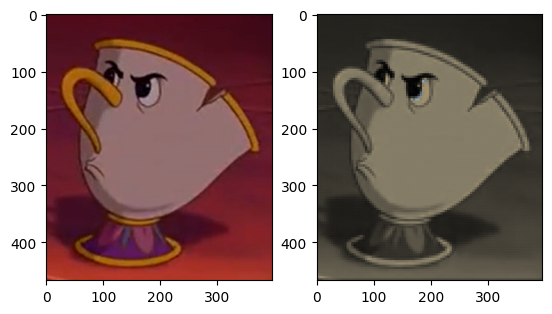

In [ ]:
import matplotlib.pyplot as plt

ax, fig = plt.subplots(1, 2)
fig[0].imshow(image)
fig[1].imshow(reconstructed_image_16)

In [ ]:
tf.image.psnr(image, reconstructed_image_16, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=18.704754>

In [ ]:
tf.image.ssim(image, reconstructed_image_16, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7886525>

In [ ]:
tf.image.ssim_multiscale(image, reconstructed_image_16, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.89841294>

In [ ]:
encoded_patches.shape

(11583, 1, 1, 1)